In [1]:
using Plots
using CSV
using DataFrames

# Points of exploration today 
* Why Julia? Why not just stick to Python? (Verbal explaination...DONE!) 
* What basic building blocks I need to do ML in Julia?
* Nice examples on Mulitple Dispatch?
* Scope of use, outside techincal computing?

## What basic building blocks I need to do ML in Julia?


### We start with functions

In [2]:
# constructing fuctions
f(x)= sin(x)+5

f (generic function with 1 method)

In [3]:
f(pi)

5.0

In [4]:
f(x)= begin 
        x^2
    end 

f (generic function with 1 method)

In [5]:
f(4)

16

In [6]:
function f(l)
    s=0
    for i=1:l 
        s+=i^3
    end
    s
end

f (generic function with 1 method)

In [7]:
f(4)

100

To see a close to the machine representation

In [8]:
@code_lowered f(4)

CodeInfo(
1 ─       s = 0
│   %2  = 1:l
│         @_4 = Base.iterate(%2)
│   %4  = @_4 === nothing
│   %5  = Base.not_int(%4)
└──       goto #4 if not %5
2 ┄ %7  = @_4
│         i = Core.getfield(%7, 1)
│   %9  = Core.getfield(%7, 2)
│   %10 = s
│   %11 = i
│   %12 = Core.apply_type(Base.Val, 3)
│   %13 = (%12)()
│   %14 = Base.literal_pow(Main.:^, %11, %13)
│         s = %10 + %14
│         @_4 = Base.iterate(%2, %9)
│   %17 = @_4 === nothing
│   %18 = Base.not_int(%17)
└──       goto #4 if not %18
3 ─       goto #2
4 ┄       return s
)

In [9]:
function f(l, init::T) where T<:Number
    s=init
    for i=T(1):T(l) 
        s+=i^3
    end
    s
end

f (generic function with 2 methods)

In [10]:
f(1000,BigInt(0))

250500250000

To investigate if we have type issues

In [11]:
@code_warntype f(1000,BigInt(0))

Variables
  #self#::Core.Compiler.Const(f, false)
  l::Int64
  init::BigInt
  s::BigInt
  @_5::Union{Nothing, Tuple{BigInt,BigInt}}
  i::BigInt

Body::BigInt
1 ─       (s = init)
│   %2  = ($(Expr(:static_parameter, 1)))(1)::BigInt
│   %3  = ($(Expr(:static_parameter, 1)))(l)::BigInt
│   %4  = (%2:%3)::UnitRange{BigInt}
│         (@_5 = Base.iterate(%4))
│   %6  = (@_5 === nothing)::Bool
│   %7  = Base.not_int(%6)::Bool
└──       goto #4 if not %7
2 ┄ %9  = @_5::Tuple{BigInt,BigInt}::Tuple{BigInt,BigInt}
│         (i = Core.getfield(%9, 1))
│   %11 = Core.getfield(%9, 2)::BigInt
│   %12 = s::BigInt
│   %13 = i::BigInt
│   %14 = Core.apply_type(Base.Val, 3)::Core.Compiler.Const(Val{3}, false)
│   %15 = (%14)()::Core.Compiler.Const(Val{3}(), false)
│   %16 = Base.literal_pow(Main.:^, %13, %15)::BigInt
│         (s = %12 + %16)
│         (@_5 = Base.iterate(%4, %11))
│   %19 = (@_5 === nothing)::Bool
│   %20 = Base.not_int(%19)::Bool
└──       goto #4 if not %20
3 ─       goto #2
4 ┄     

Note to Python lovers.... BigInit was a overkill for this range... Int128 would do it... in blink of an eye

In [12]:
f(100000000, Int128(0))

25000000500000002500000000000000

To check the range.

In [13]:
typemax(Int128)

170141183460469231731687303715884105727

That means that we can go even higher (I just added another zero)... try that in Python. 

In [14]:
f(1000000000, Int128(0))

250000000500000000250000000000000000

The Generic function working on `Float64`... also super fast

In [15]:
f(100000000, 0.0)

2.5000000500004043e31

Simplifying this a bit with not initial value

In [16]:
function f(l::T) where T<:Number
    s=zero(l)
    for i=T(1):T(l) 
        s+=i^3
    end
    s
end

f (generic function with 3 methods)

In [17]:
f(Int128(100000000))

25000000500000002500000000000000

Further simplificaiton using a generator

In [18]:
f(x)=sum(i^3 for i=one(x):x)

f (generic function with 3 methods)

In [19]:
f(Int128(100000000))

25000000500000002500000000000000

A quick intro to generators 

In [20]:
gen=(i^3 for i=1:10)

Base.Generator{UnitRange{Int64},var"#5#6"}(var"#5#6"(), 1:10)

In [21]:
for i in gen 
    print(i," ")
end

1 8 27 64 125 216 343 512 729 1000 

In [22]:
g(x,y)=x+y

g (generic function with 1 method)

In [23]:
g(5,2)

7

In [24]:
a=[5,7]

2-element Array{Int64,1}:
 5
 7

A bit of splatting 

In [25]:
g(a...)

12

In [26]:
map(x->x^3,1:15) 

15-element Array{Int64,1}:
    1
    8
   27
   64
  125
  216
  343
  512
  729
 1000
 1331
 1728
 2197
 2744
 3375

An alternative syntax with `do`

In [27]:
map(1:15) do x
    x^3
end

15-element Array{Int64,1}:
    1
    8
   27
   64
  125
  216
  343
  512
  729
 1000
 1331
 1728
 2197
 2744
 3375

### A quick dive into plotting 

In [28]:
using Plots

This is a super package. It uses many backends... checkout their website http://docs.juliaplots.org/latest/

We start with the plotlyjs() backend.... It generates Javascript plots that are interactive. 

In [29]:
plotlyjs()

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-2821048036778668025\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-4790458221826594886\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-2821048036778668025\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

Plots.PlotlyJSBackend()

In [30]:
plot(sin)

[5597:0422/111808.933708:ERROR:buffer_manager.cc(488)] [.DisplayCompositor]GL ERROR :GL_INVALID_OPERATION : glBufferData: <- error from previous GL command


<!DOCTYPE html>
 
 
 Plots.jl

You can save it as an `html` file and put it on a web page. 

In [31]:
savefig("myplot.html")

You could have added an extra argument as in 

```julia
savefig("myplot.html",js)
```

The `js` argument can be one of
- `:local`: Reference the local plotly.js file included in this Julia package
    Pros: small file size, offline viewing. Cons: Can't share with others or
    move to different machine..
- `:remote`: Reference plotly.js from a CDN. Pros small file size, move to
    other machine. Cons: need internet access to fetch from CDN
- `:embed`: Embed the entirety of your local copy of plotly.js in the
    outputted file. Pros: offline viewing, move to other machine. Con: large
    file size (adds about 2.7 MB)

GR is the default backend is generally quite good. Though it lacks the interactive elements

In [32]:
gr()

Plots.GRBackend()

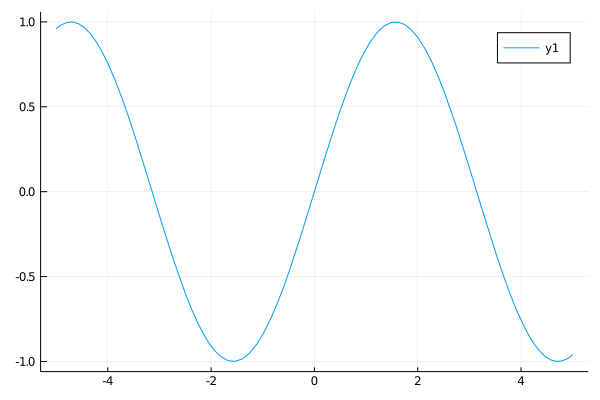

In [33]:
p=plot(sin)

With `Plots` you can do a bit of composition 

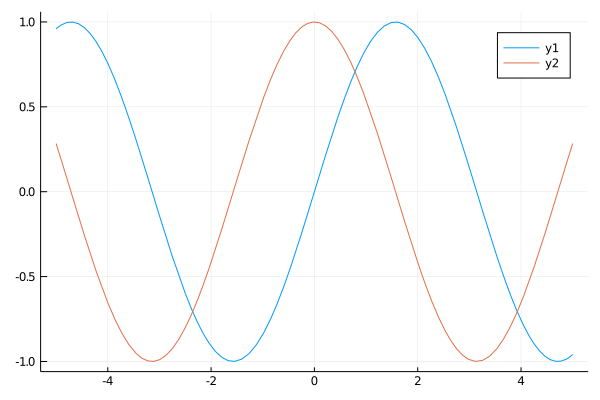

In [34]:
plot!(p,cos)

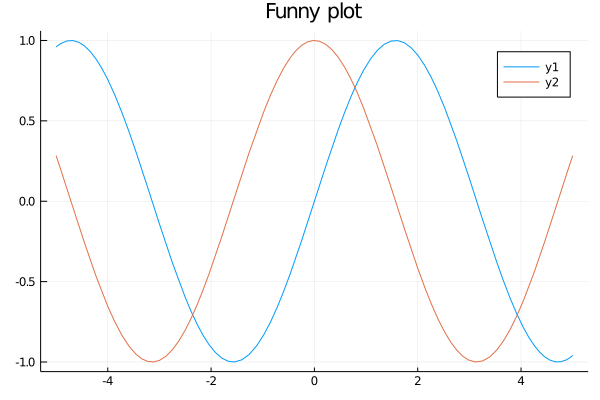

In [35]:
title!("Funny plot")

### Some basis regression 

In [36]:
x=rand(100)*10
y=3*x+randn(length(x)) .+5;

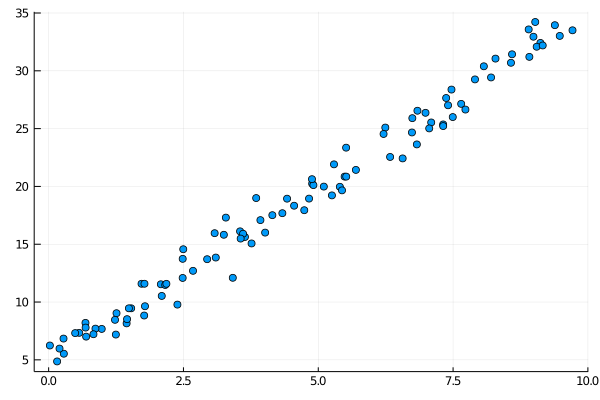

In [37]:
scatter(x,y, label="")

In a point by point approach 

$y=mx+b$

Expressing this is matrix notation 

$\mathbf{y}=[\mathbf{x} \quad \mathbf{1}] \Phi $. 

$\Phi=[m \quad b]$


We use below the inverse divide to extract the $\Phi$ parameter. Here we are using implicitly doing pseduo inverse. 
See for referance [slide 7](https://stanford.edu/class/ee103/julia_slides/julia_inverses_slides.pdf)

$$x=A^T(AA^T)^{-1}b$$

or what we expressed earlier 
$A=[\mathbf{x} \quad \mathbf{1}]$ and $b=y$ and $x=\Phi$

In [38]:
Φ=[x ones(length(x))]\y

2-element Array{Float64,1}:
 2.9872187455201678
 5.030057151747883

In [39]:
u(x)=Φ[1]*x+Φ[2]

u (generic function with 1 method)

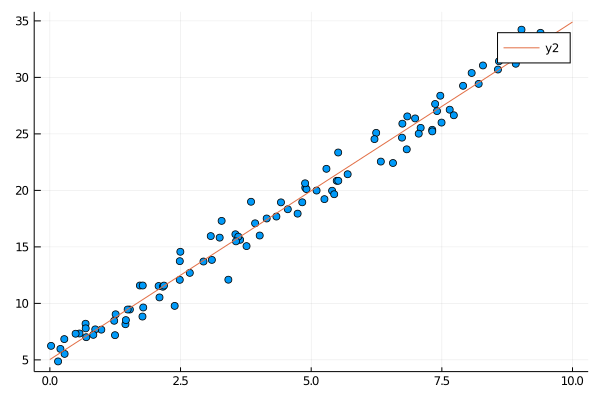

In [40]:
scatter(x,y, label="")
plot!(0:0.1:10,u)

If we want to fit a second order polynomial 
$$y=w_0+w_1*x+w_2*x^2$$

In [41]:
x=rand(100)*10
y=sin.(x)+randn(length(x))*0.2
w=[ones(length(x)) x x.^2]\y

3-element Array{Float64,1}:
  1.0070171145053368
 -0.4398382584040861
  0.039573400134892245

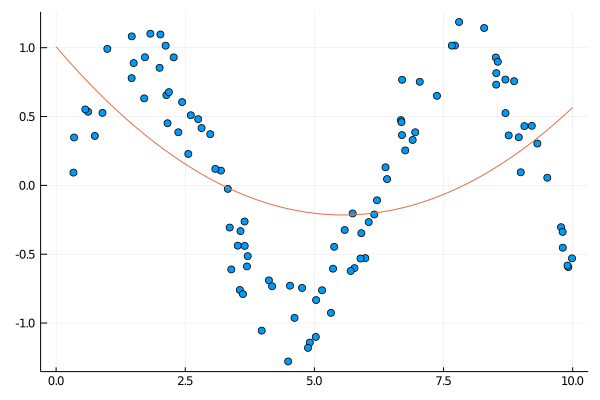

In [42]:
scatter(x,y, legend=false)
plot!(0:0.1:10, x->sum(w[i]*x^(i-1) for i in eachindex(w)))

We can now write very concise code to fitting any $n$ order polynomial

In [43]:
n=5
w=hcat(ones(length(x)), [x.^i for i=1:n]...)\y

6-element Array{Float64,1}:
 -1.3030466891996142
  4.354232922509118
 -2.517916062144582
  0.5231939836612408
 -0.0443547044313094
  0.001291330170785204

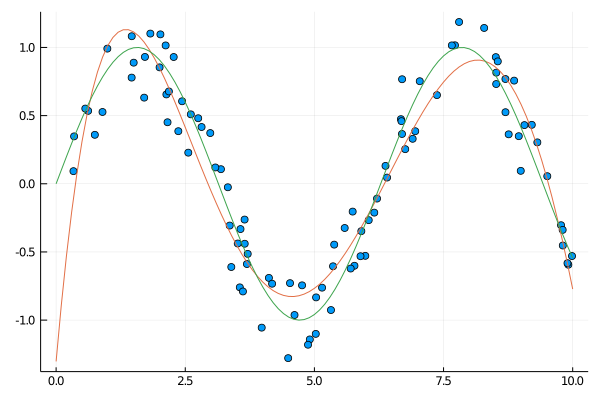

In [44]:
scatter(x,y, legend=false)
plot!(0:0.1:10, x->sum(w[i]*x^(i-1) for i in eachindex(w)))
plot!(0:0.1:10,sin)